## 📙 SET THE NAME AND MAIN PARAMETERS

In [1]:
name = "adaboost"

enable_mixed_precision = True

use_augmentation = False
multipler = 4
epochs = 50
batch_size = 128
learning_rate = 1e-5 #DO NOT INCREASE IF USING MIXED PRECISION

save_model = True
prepare_submission = True

verbose = True

## ⚙️ Import Libraries

In [2]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Writing requirements.txt


In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tens

In [4]:
import numpy as np

import tensorflow as tf
import keras as tfk
from keras import mixed_precision
from keras.mixed_precision import LossScaleOptimizer
from keras import layers as tfkl
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model, Sequential
from keras.applications import ConvNeXtTiny, VGG16, VGG19, EfficientNetV2B3, ResNet101V2, InceptionV3, DenseNet169, MobileNetV2 # Add more
import keras_cv

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

from datetime import datetime

from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier

import math
from sklearn.base import BaseEstimator, ClassifierMixin

2024-11-24 18:21:40.244309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 18:21:40.265430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 18:21:40.272049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


In [6]:
# Set the keras global policy to mixed precision
if enable_mixed_precision:
    mixed_precision.set_global_policy('mixed_float16')
    print(mixed_precision.global_policy())

<DTypePolicy "mixed_float16">


In [7]:
# Set random seed
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

## ⏳ Load the Data

In [8]:
# Load data
data = np.load("/kaggle/input/hbntlualk-khahzla-zwspa/augmented_split_dataset.npz")

In [9]:
X_test = data['X_test']
y_test = data['y_test']
X=data['X_train']
y=data['y_train']
X_train = X
y_train = y
print('Training + Validation set shape:\t', X_train.shape, y_train.shape)
print('Test set shape:\t', X_test.shape, y_test.shape)

Training + Validation set shape:	 (40632, 96, 96, 3) (40632, 8)
Test set shape:	 (1793, 96, 96, 3) (1793, 8)


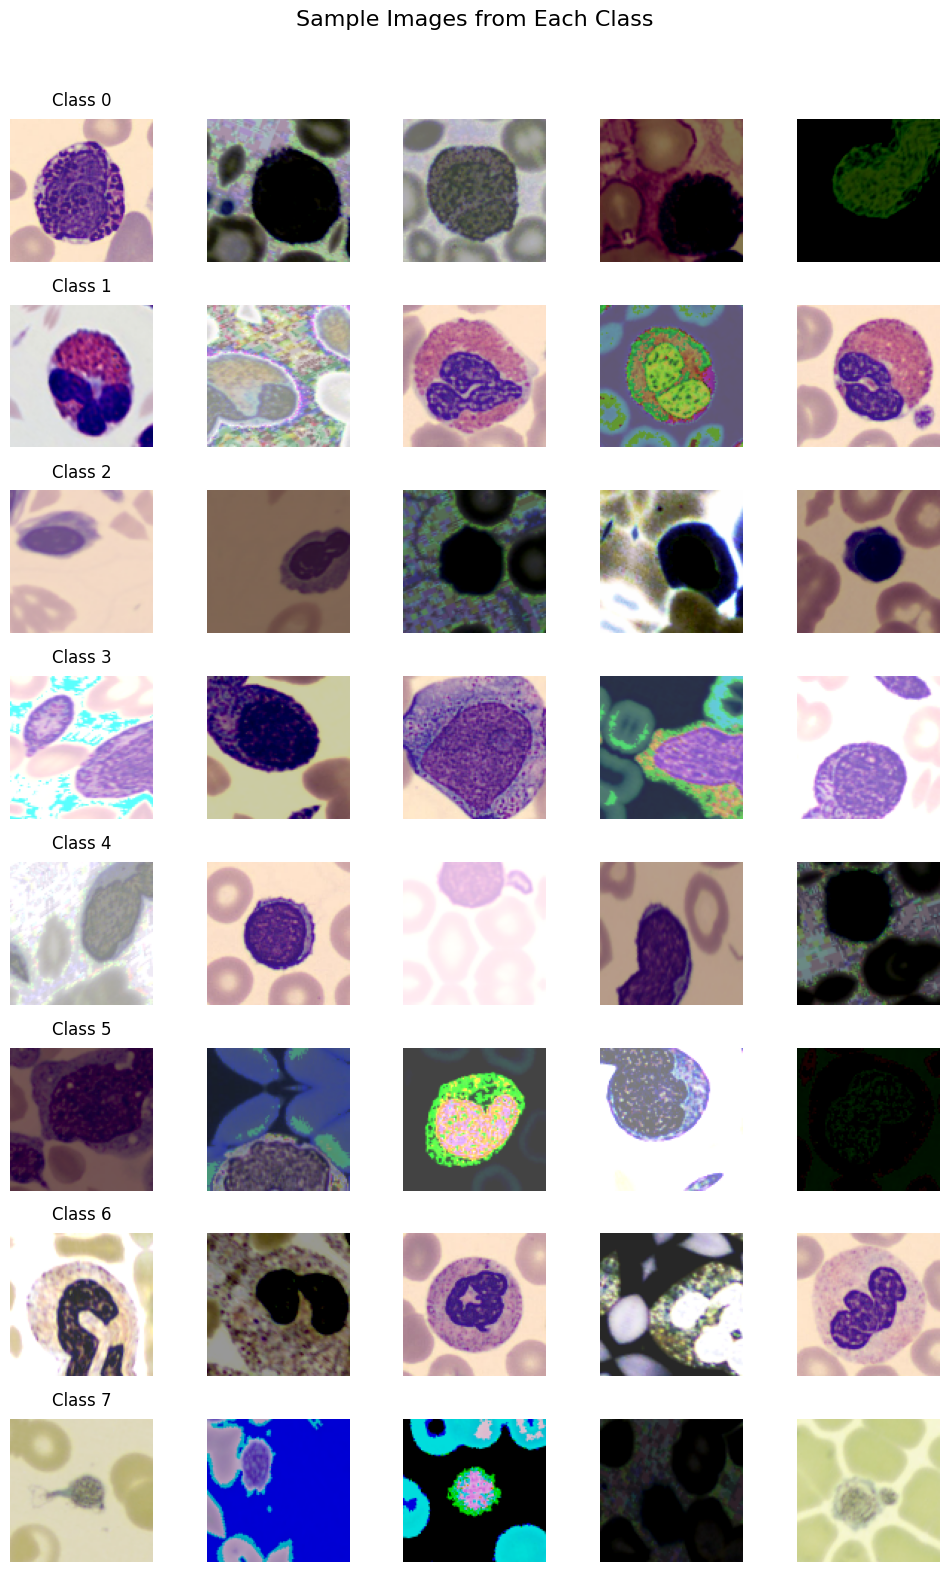

In [10]:
# Number of samples to display per class
samples_per_class = 5
unique_classes = range(y.shape[1])  # Assuming classes are labeled from 0 to n-1

# Adjust figure size and remove extra spacing between plots
fig, axes = plt.subplots(len(unique_classes), samples_per_class, figsize=(samples_per_class * 2, len(unique_classes) * 2))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for class_idx in unique_classes:
    # Find indices of samples for this class
    class_indices = np.where(np.argmax(y, axis=1) == class_idx)[0]
    # Randomly select images from this class
    selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(X[idx].astype("uint8"))  # Convert to uint8 if needed for display
        ax.axis("off")
        if i == 0:
            ax.set_title(f"Class {class_idx}", fontsize=12, pad=10)  # Add padding to title

# Adjust layout to reduce spacing
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

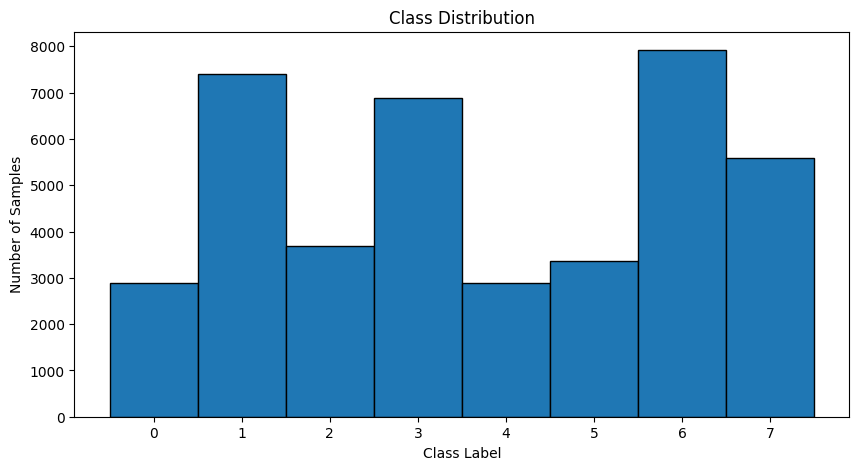

In [11]:
if verbose:
    class_labels = np.argmax(y, axis=-1)
    plt.figure(figsize=(10, 5))  # Adjust figure size if needed
    plt.hist(class_labels, bins=np.arange(9) - 0.5, edgecolor='black')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(np.arange(8))  # Set x-axis ticks to represent class labels
    plt.show()

# Data augmentation

In [12]:
# Ottieni la policy standard di RandAugment
policy_layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255),
    magnitude=0.30,
    magnitude_stddev=0.3,
)

#layer da rimuovere da policy
layers_to_remove = (
    keras_cv.layers.RandomContrast,
    keras_cv.layers.RandomColorDegeneration,
    keras_cv.layers.RandomBrightness
)

filtered_layers = [
    layer for layer in policy_layers
    if not isinstance(layer, layers_to_remove)
]

all_layers = filtered_layers + [tf.keras.layers.GaussianNoise(0.3)]


#Definisci la pipeline completa di augmentazione
augmentation = tf.keras.Sequential([
    keras_cv.layers.RandomAugmentationPipeline(
        layers = all_layers,
        augmentations_per_image=3,  # Numero di trasformazioni da applicare per immagine
        rate=1.0  # Probabilità di applicare ciascuna trasformazione
    ),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(1),
    tf.keras.layers.RandomContrast(0.65),
    tf.keras.layers.RandomBrightness(0.50)
    #keras_cv.layers.RandomColorDegeneration(factor=0.1),
], name='Augmentation')

I0000 00:00:1732472539.818313      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732472539.828488      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732472539.828785      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732472539.830664      30 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [13]:
if use_augmentation:
    def augment_training_set(X_train, y_train, augmentation):
        multiplier = multipler

        # Lists to hold augmented images and labels
        augmented_X = []
        augmented_y = []

        # Loop over all classes
        for class_label in range(y_train.shape[1]):
            # Find indices of the current class (assuming y_train is one-hot encoded)
            class_indices = np.where(y_train[:, class_label] == 1)[0]
            X_class = X_train[class_indices]

            # Numero di immagini originali per la classe corrente
            original_count = len(X_class)

            # Calcola il numero di immagini aumentate necessarie
            target_samples = math.ceil(original_count * multiplier)
            n_needed = target_samples - original_count

            if n_needed <= 0:
                continue  # Skip if class already has enough samples

            # Generate augmented images in batches
            batch_size = 32  # Adjust batch size as needed
            num_batches = n_needed // batch_size + (n_needed % batch_size > 0)

            for _ in tqdm(range(num_batches)):
                 # Randomly select images from the class for batch augmentation
                idxs = np.random.choice(len(X_class), size=min(batch_size, n_needed))
                img_batch = X_class[idxs]

                # Apply augmentation to the entire batch
                img_augmented_batch = augmentation(tf.convert_to_tensor(img_batch))
                augmented_X.extend(img_augmented_batch.numpy())  # Add batch of images to list
                augmented_y.extend([class_label] * len(img_batch))  # Add corresponding labels

                # Reduce n_needed by batch size to avoid extra samples
                n_needed -= len(img_batch)
                if n_needed <= 0:
                    break  # Stop if we reach the target number

        # Convert augmented data lists to numpy arrays
        augmented_X = np.array(augmented_X, dtype=np.float32)  # Ensure float32 for compatibility with model input
        augmented_y = np.array(augmented_y, dtype=int)  # Ensure integer type for labels

        # Convert augmented_y to one-hot encoding format
        augmented_y_one_hot = np.zeros((len(augmented_y), y_train.shape[1]))
        augmented_y_one_hot[np.arange(len(augmented_y)), augmented_y] = 1

        # Concatenate original and augmented data
        X_train = np.concatenate((X_train, augmented_X), axis=0)
        y_train = np.concatenate((y_train, augmented_y_one_hot), axis=0)

        print(f"New training set size: {X_train.shape}, {y_train.shape}")

        return X_train, y_train

### Let's see distribution now

## 🧮 Define Network Parameters

In [14]:
# Input shape for the model
input_shape = X.shape[1:]

# Output shape for the model
output_shape = y.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [15]:
# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 50
Batch Size: 128
Learning Rate: 1e-05


## 🛠️ Train and Save the Model

In [16]:
def build_model(

    input_shape=input_shape,

    output_shape=output_shape,

    learning_rate=learning_rate,

    augmentation=None,

    seed=seed

):

        # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Block 1
    x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(input_layer)
    x = tfkl.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Block 2
    x = tfkl.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Block 3
    x = tfkl.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Block 4
    x = tfkl.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Block 5
    x = tfkl.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Block 6
    x = tfkl.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Fully connected layers
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dense(256, activation='relu')(x)

    # Output layer
    output_layer = tfkl.Dense(8, activation='softmax')(x)


    # Output layer
    output_layer = tfkl.Dense(8, activation='softmax')(x)         # Output layer with 8 classes

    # Create and compile the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer)

    return model




In [17]:
class KerasBaseClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, input_shape, num_classes, epochs=50, batch_size=32, patience=5):
        """
        Wrapper for Keras model to be used in scikit-learn.
        """
        self.build_fn = build_fn
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.model = None
        self.history = None  # Store training history



    def fit(self, X, y, sample_weight=None):

        # Convert labels to one-hot encoding
        y_one_hot = tf.keras.utils.to_categorical(y, self.num_classes)

        # Build and compile the model
        self.model = self.build_fn(self.input_shape, self.num_classes)
        self.model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='accuracy',  # Monitor training loss (AdaBoost typically doesn't use validation)
            patience=self.patience,
            restore_best_weights=True,
            verbose=1
        )

        # Train the model with support for sample weights
        self.history = self.model.fit(
            X, y_one_hot,
            epochs=self.epochs,
            batch_size=self.batch_size,
            sample_weight=sample_weight,  # Pass sample weights
            callbacks=[early_stopping],
            verbose=1  # Set to 1 for progress output, 0 for silent mode
        )

        # Assign the classes_ attribute for compatibility with scikit-learn
        self.classes_ = np.unique(y)
        return self


    def predict(self, X):
        """
        Predict class labels.
        """
        predictions = self.model.predict(X)
        return np.argmax(predictions, axis=1)

    def predict_proba(self, X):
        """
        Predict class probabilities.
        """
        return self.model.predict(X)

## 🧠 Train the Model

In [18]:
#Augmentation
if use_augmentation:
    X_train, y_train = augment_training_set(X_train, y_train, augmentation)


base_clf = KerasBaseClassifier(build_model, input_shape, output_shape, epochs=epochs, batch_size=batch_size)

# Use AdaBoostClassifier
myModel = AdaBoostClassifier(estimator=base_clf, n_estimators=50, random_state=42, algorithm="SAMME")
original_labels = np.argmax(y_train, axis=1)
myHistory = myModel.fit(X_train, original_labels)

Epoch 1/50


I0000 00:00:1732472560.557575     108 service.cc:146] XLA service 0x7ebe3c004090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732472560.557642     108 service.cc:154]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/318 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.1402 - loss: 6.0555e-05   

I0000 00:00:1732472575.156646     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


318/318 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.3828 - loss: 4.0589e-05
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6257 - loss: 2.4648e-05
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7116 - loss: 1.9143e-05
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7669 - loss: 1.5520e-05
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8064 - loss: 1.3024e-05
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8396 - loss: 1.0946e-05
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8576 - loss: 9.5735e-06
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8780 - loss: 8.2578e-06
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8955 - loss: 7.1801e-06
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9048 - loss: 6.4074e-06
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9186 - loss: 5.4931e-

In [19]:
# Accuracy on the training set
train_accuracy = myModel.score(X_train, original_labels)  # For one-hot, use np.argmax(y_train, axis=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
# Test or validation labels (integer, not one-hot encoded)
test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels if necessary

# Accuracy on the test set
test_accuracy = myModel.score(X_test, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
predictions = myModel.predict(X_test)

1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Training Accuracy: 96.63%
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/st

In [20]:
from tensorflow.keras.models import save_model
import joblib

def save_boosted_model(adaboost_model, keras_model_path='model.keras', adaboost_path='adaboost_model.pkl'):
    if hasattr(adaboost_model, 'estimator_') and adaboost_model.estimator_ is not None:
        base_estimator = adaboost_model.estimator_
        if hasattr(base_estimator, 'model'):
            keras_model = base_estimator.model

            # Ensure the Keras model is built
            if not keras_model.built:
                dummy_input = tf.random.uniform((1,) + keras_model.input_shape[1:])
                keras_model(dummy_input)

            # Save the Keras model
            save_model(keras_model, keras_model_path)
            print(f"Keras model saved to {keras_model_path}")
        else:
            raise ValueError("The base estimator does not expose a 'model' attribute.")
    else:
        raise ValueError("AdaBoost estimator is not properly initialized or not trained yet.")

    # Save the AdaBoost model
    joblib.dump(adaboost_model, adaboost_path)
    print(f"AdaBoost model saved to {adaboost_path}")



# Load the boosted model
def load_boosted_model(keras_model_path='model.keras', adaboost_path='adaboost_model.pkl'):
    # Load the AdaBoost wrapper
    adaboost_model = joblib.load(adaboost_path)
    print(f"AdaBoost model loaded from {adaboost_path}")

    # Load the Keras model and assign it back as the base estimator
    adaboost_model.estimator_ = load_model(keras_model_path)
    print(f"Keras model loaded from {keras_model_path}")

    return adaboost_model

In [21]:
# Check if build_fn creates a valid model
keras_model = myModel.estimator_.build_fn(input_shape=(96, 96, 3), output_shape=8)
keras_model.summary()  # This should display the architecture of the Keras model
myModel.estimator_.model = keras_model

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_300 (Conv2D)             │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_301 (Conv2D)             │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_120               │ (None, 48, 48, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_302 (Conv2D)             │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_303 (Conv2D)             │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_304 (Conv2D)             │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_141         │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_121               │ (None, 24, 24, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_305 (Conv2D)             │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_306 (Conv2D)             │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_142         │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_122               │ (None, 12, 12, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_307 (Conv2D)             │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_308 (Conv2D)             │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_309 (Conv2D)             │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_143         │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_123               │ (None, 6, 6, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_310 (Conv2D)             │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_311 (Conv2D)             │ (None, 6, 6, 256)      │       590,08

 Total params: 3,375,864 (12.88 MB)

 Trainable params: 3,373,336 (12.87 MB)

 Non-trainable params: 2,528 (9.88 KB)

In [23]:
# Save the boosted model
save_boosted_model(myModel, keras_model_path='model.keras', adaboost_path='adaboost_model.pkl')

Keras model saved to model.keras
AdaBoost model saved to adaboost_model.pkl


## 📊 Prepare Your Submission 

In [24]:
filename = "model.py"


content = '''import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import joblib

class Model:
    def __init__(self):
        self.model = tfk.models.load_model('model.keras')
        # Load the AdaBoost model
        self.adaboost_model = joblib.load('adaboost_model.pkl')
        # Assign the Keras model back to AdaBoost
        self.adaboost_model.estimator_ = self.model

    def predict(self, X):
        preds = self.adaboost_model.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=-1)
        return preds'''

In [25]:
# Write the content to the chosen file
with open(filename, "w") as file:
    file.write(content)

print(f"Content written to {filename}")

Content written to model.py


In [26]:
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}_{name}.zip'

# Add files to the zip command if needed
!zip {filename} model.py model.keras adaboost_model.pkl

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model.py (deflated 55%)
  adding: model.keras (deflated 10%)
  adding: adaboost_model.pkl (deflated 14%)


In [27]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(filename)

/kaggle/working


/kaggle/working/submission_241124_195633_adaboost.zip